In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import roc_auc_score
import keras.backend as K
from collections import OrderedDict
from keras.models import Model
import seaborn as sns

print(f'tf={tf.__version__}, keras={keras.__version__}')

Using TensorFlow backend.


tf=1.14.0, keras=2.2.4-tf


In [2]:
SEED = 31
EPOCHS = 100
BATCH_SIZE = 128
TARGET = 'isFraud'
VALIDATION_PERCENT = 0.08
DROPOUT_RATE = 0.5  #0.2
L2 = 0.0001  #0.00001
LEARNING_RATE = 0.002
HIDDEN_UNITS = 200  #256
HIDDEN_LAYERS = 2  #4
PATIENCE = 4
DECAY_RATE = 0.5
DECAY_STEPS = 4

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)


seed_everything(SEED)

In [4]:
file_folder = '../input/ieee-fraud-detection-preprocess'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 375 entries, isFraud to _pc_18
dtypes: float64(374), int64(1)
memory usage: 1.6 GB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 374 entries, TransactionAmt to _pc_18
dtypes: float64(374)
memory usage: 1.4 GB


In [6]:
def group_ratios_and_pcs():
    excludes = {TARGET}
    for i in range(1, 340):
        excludes.add(f'V{i}')
    cols = set(train.columns.values) - excludes
    return list(cols)


def _keep(col):
    if col == TARGET:
        return False
    if col.startswith('_pc_'):
        return False
    #if '_to_' in col:
     #   return False
    return True


PREDICTORS = [c for c in train.columns.values if _keep(c)]
#PREDICTORS = group_ratios_and_pcs()
print(f'{len(PREDICTORS)} predictors={PREDICTORS}')

355 predictors=['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97'

In [7]:
val_size = int(VALIDATION_PERCENT * len(train))
train, val = train[:-val_size], train[-val_size:]
print(f'train={train.shape}, val={val.shape}')

train=(543297, 375), val=(47243, 375)


In [8]:
y_train = train[TARGET]
x_train = train[PREDICTORS]
y_val = val[TARGET]
x_val = val[PREDICTORS]
x_test = test[PREDICTORS]

# Compute ROC-AUC after each epoch
Based on https://stackoverflow.com/a/46844409/519951

In [9]:
class AucRocCallback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)[:,1]
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)[:,1]
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('epoch=%d, roc-auc: val=%s, train=%s' % (epoch,str(round(roc_val,4)),str(round(roc,4))))
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [10]:
def build_model(input_shape):
  #ini = keras.initializers.he_uniform()
  ini = keras.initializers.he_normal()
  reg = regularizers.l2(L2)  

  def _block():
    res = []
    for i in range(HIDDEN_LAYERS):
        if i == 0:
            res.append(layers.Dense(HIDDEN_UNITS,
                                    activation=tf.nn.relu,
                                    kernel_initializer=ini,
                                    kernel_regularizer=reg,
                                    input_shape=input_shape,
                                    name=f'dense_{i}'))
        else:
            res.append(layers.Dense(HIDDEN_UNITS,
                                    activation=tf.nn.relu,
                                    kernel_initializer=ini,
                                    kernel_regularizer=reg,
                                    name=f'dense_{i}'))
        res.append(layers.BatchNormalization(name=f'batch_norm_{i}'))
        res.append(layers.Dropout(DROPOUT_RATE, name=f'dropout_{i}'))
    return res
  
  hls = _block()
  model = keras.Sequential(hls + [
    layers.Dense(2, activation=tf.nn.softmax, name='output')
  ])
  opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
  return model


model = build_model(input_shape=[len(x_train.keys())])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 200)               71200     
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 200)               800       
_________________________________________________________________
dropout_0 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 4

In [11]:
# sanity check model is producing output of desired type and shape
example_batch = x_train[:10]
example_result = model.predict(example_batch)
example_result

array([[0.73517704, 0.264823  ],
       [0.3840061 , 0.6159939 ],
       [0.33923852, 0.6607615 ],
       [0.50848895, 0.49151105],
       [0.50392747, 0.49607253],
       [0.37182468, 0.6281753 ],
       [0.81454533, 0.1854547 ],
       [0.55107975, 0.44892022],
       [0.5835161 , 0.41648385],
       [0.47371954, 0.5262805 ]], dtype=float32)

# Log weights

In [12]:
def calc_stats(W):
    return np.linalg.norm(W, 2), np.mean(W), np.std(W)


class MyDebugWeights(keras.callbacks.Callback):
    
    def __init__(self):
        super(MyDebugWeights, self).__init__()
        self.weights = []
        self.tf_session = K.get_session()
            
    def on_epoch_end(self, epoch, logs=None):
        for layer in self.model.layers:
            name = layer.name
            for i, w in enumerate(layer.weights):
                w_value = w.eval(session=self.tf_session)
                w_norm, w_mean, w_std = calc_stats(np.reshape(w_value, -1))
                self.weights.append((epoch, "{:s}/W_{:d}".format(name, i), 
                                     w_norm, w_mean, w_std))
    
    def on_train_end(self, logs=None):
        for e, k, n, m, s in self.weights:
            print("{:3d} {:30s} {:7.3f} {:7.3f} {:7.3f}".format(e, k, n, m, s))
            


class WeightsLogger(keras.callbacks.Callback):
    
    def __init__(self):
        super(WeightsLogger, self).__init__()
        self.weights = pd.DataFrame(columns=['layer', 'target'])
        self.tf_session = K.get_session()
            
    def on_epoch_end(self, epoch, logs=None):
        for i, layer in enumerate(self.model.layers):
            name = layer.name
            if not name.startswith('dense_'):
                continue
            for w in layer.weights:
                w_value = w.eval(session=self.tf_session)
                tmp = pd.DataFrame(columns=['layer', 'target'])
                tmp['target'] = np.reshape(w_value, -1)
                tmp['layer'] = name
                self.weights = pd.concat([self.weights, tmp])
    

weights_logger = WeightsLogger()

# Learning rate scheduler

In [13]:
def _learning_rate_scheduler(decay_rate, decay_steps):
    
    def _scheduler(epoch, lr):
        if (epoch + 1) % decay_steps == 0:
            return lr * decay_rate
        return lr

    return keras.callbacks.LearningRateScheduler(_scheduler, verbose=0)


lr_scheduler = _learning_rate_scheduler(decay_rate=DECAY_RATE, decay_steps=DECAY_STEPS)

# Train model
Log gradients, adapted from https://stackoverflow.com/questions/45694344/calculating-gradient-norm-wrt-weights-with-keras

In [14]:
%%time
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

auc_roc = AucRocCallback(training_data=(x_train, y_train), validation_data=(x_val, y_val))

def get_gradient_norm_func(model):
    grads = K.gradients(model.total_loss, model.trainable_weights)
    #summed_squares = [K.sum(K.square(g)) for g in grads]
    #norm = K.sqrt(sum(summed_squares))
    inputs = model._feed_inputs + model._feed_targets + model._feed_sample_weights
    func = K.function(inputs, [grads])
    return func


# must be placed right before fitting the model
get_gradient = get_gradient_norm_func(model)
history = model.fit(
  x_train, y_train,
  epochs=EPOCHS, verbose=0, batch_size=BATCH_SIZE, validation_data=(x_val, y_val),
  callbacks=[auc_roc, early_stop, lr_scheduler, weights_logger])

epoch=0, roc-auc: val=0.8617, train=0.8531
epoch=1, roc-auc: val=0.8672, train=0.8662
epoch=2, roc-auc: val=0.8743, train=0.8694
epoch=3, roc-auc: val=0.8755, train=0.8725
epoch=4, roc-auc: val=0.8677, train=0.8691
epoch=5, roc-auc: val=0.8766, train=0.8726
epoch=6, roc-auc: val=0.8726, train=0.8751
epoch=7, roc-auc: val=0.8786, train=0.8821
epoch=8, roc-auc: val=0.8872, train=0.8855
epoch=9, roc-auc: val=0.8847, train=0.8866
epoch=10, roc-auc: val=0.8805, train=0.8821
epoch=11, roc-auc: val=0.8885, train=0.8931
epoch=12, roc-auc: val=0.8895, train=0.8942
epoch=13, roc-auc: val=0.8902, train=0.8961
epoch=14, roc-auc: val=0.8909, train=0.8944
epoch=15, roc-auc: val=0.8948, train=0.8993
epoch=16, roc-auc: val=0.893, train=0.9008
epoch=17, roc-auc: val=0.8945, train=0.901
epoch=18, roc-auc: val=0.8957, train=0.9035
epoch=19, roc-auc: val=0.8965, train=0.9066
epoch=20, roc-auc: val=0.8975, train=0.9082
epoch=21, roc-auc: val=0.897, train=0.9086
epoch=22, roc-auc: val=0.8978, train=0.9102
e

# Inspect gradients

In [15]:
model.trainable_weights

[<tf.Variable 'dense_0/kernel:0' shape=(355, 200) dtype=float32>,
 <tf.Variable 'dense_0/bias:0' shape=(200,) dtype=float32>,
 <tf.Variable 'batch_norm_0/gamma:0' shape=(200,) dtype=float32>,
 <tf.Variable 'batch_norm_0/beta:0' shape=(200,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(200, 200) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(200,) dtype=float32>,
 <tf.Variable 'batch_norm_1/gamma:0' shape=(200,) dtype=float32>,
 <tf.Variable 'batch_norm_1/beta:0' shape=(200,) dtype=float32>,
 <tf.Variable 'output/kernel:0' shape=(200, 2) dtype=float32>,
 <tf.Variable 'output/bias:0' shape=(2,) dtype=float32>]

In [16]:
len(model.trainable_weights)

10

In [17]:
%%time
gs = get_gradient([x_train, y_train, np.ones(len(y_train))])[0]
print(f'len(gs)={len(gs)}')
gradients = pd.DataFrame(columns=['layer', 'target'])
node_names = [w.name for w in model.trainable_weights]
for i, node in enumerate(node_names):
    if node.startswith('dense_0'):
        layer = 'h0'
    elif node.startswith('dense_1'):
        layer = 'h1'
    elif node.startswith('dense_2'):
        layer = 'h2'
    elif node.startswith('dense_3'):
        layer = 'h3'
    elif node.startswith('dense_4'):
        layer = 'h4'
    else:
        continue
    tmp = pd.DataFrame(columns=['layer', 'target'])
    tmp['target'] = gs[i].flatten()
    tmp['layer'] = layer
    gradients = pd.concat([gradients, tmp])
    
    
gradients.info()

len(gs)=10
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111400 entries, 0 to 199
Data columns (total 2 columns):
layer     111400 non-null object
target    111400 non-null float32
dtypes: float32(1), object(1)
memory usage: 2.1+ MB
CPU times: user 1.63 s, sys: 872 ms, total: 2.5 s
Wall time: 2.52 s


In [18]:
g_stats = gradients.groupby(['layer'])['target'].agg(['median', 'std', 'min', 'max', 'skew'])
g_stats.head(10)

,median,std,min,max,skew
layer,,,,,
h0,-1.165619e-35,0.000209,-0.010274,0.003188,-4.522439
h1,1.261000e-36,0.000058,-0.000540,0.000527,0.273729


Text(0.5, 1.0, 'Gradients')

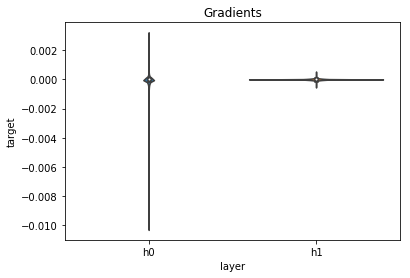

In [19]:
g_ax = sns.violinplot(x='layer', y='target', data=gradients)
g_ax.set_title('Gradients')

# Inspect weights

In [20]:
weights = weights_logger.weights
weights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3453400 entries, 0 to 199
Data columns (total 2 columns):
layer     object
target    float32
dtypes: float32(1), object(1)
memory usage: 65.9+ MB


In [21]:
w_stats = weights.groupby(['layer'])['target'].agg(['median', 'std', 'min', 'max', 'skew'])
w_stats.head(HIDDEN_LAYERS * 10)

,median,std,min,max,skew
layer,,,,,
dense_0,-6.123453e-32,0.030056,-1.060330,0.941722,-4.109203
dense_1,-2.187041e-32,0.037846,-0.645425,1.216094,11.637866


Text(0.5, 1.0, 'Weights')

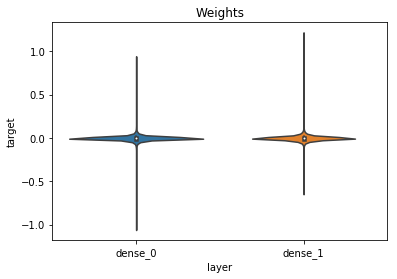

In [22]:
w_ax = sns.violinplot(x='layer', y='target', data=weights)
w_ax.set_title('Weights')

# Inspect activations

In [23]:
_sample = train.sample(n=1000)
x_sample = _sample[PREDICTORS]
y_sample = _sample[TARGET]
activations = pd.DataFrame(columns=['layer', 'target'])
#layers = ['dense_0', 'dense_1']
layers = []
for i in range(HIDDEN_LAYERS):
    layers.append(f'batch_norm_{i}')

for i, layer in enumerate(layers):
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    intermediate_output = intermediate_layer_model.predict(x_sample)
    tmp = pd.DataFrame(columns=['layer', 'target'])
    tmp['target'] = [a for example in intermediate_output for a in example]
    tmp['layer'] = f'h{i}'
    activations = pd.concat([activations, tmp])
  
activations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 199999
Data columns (total 2 columns):
layer     400000 non-null object
target    400000 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.2+ MB


In [24]:
stats = activations.groupby(['layer'])['target'].agg(['median', 'std', 'min', 'max', 'skew'])
stats.head(len(layers))

,median,std,min,max,skew
layer,,,,,
h0,-1.649988e-01,0.732646,-1.543852,25.419794,4.878121
h1,-5.046107e-07,0.237948,-1.254865,2.817132,0.649367


Text(0.5, 1.0, 'Activations')

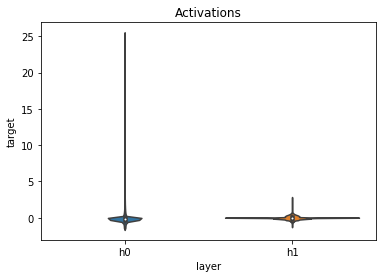

In [25]:
ax = sns.violinplot(x='layer', y='target', data=activations)
ax.set_title('Activations')

# Plot training vs validation errors

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(EPOCHS)

,loss,acc,val_loss,val_acc,lr,epoch
0,0.169626,0.964382,0.137285,0.967276,0.002000,0
1,0.127396,0.969411,0.130625,0.965265,0.002000,1
2,0.124791,0.969328,0.125804,0.965984,0.002000,2
3,0.116669,0.970243,0.117782,0.968757,0.001000,3
4,0.114803,0.970618,0.122899,0.966641,0.001000,4
5,0.114735,0.970293,0.116387,0.969837,0.001000,5
6,0.114078,0.970515,0.120187,0.966746,0.001000,6
7,0.109920,0.971364,0.115014,0.968503,0.000500,7
8,0.108515,0.971528,0.112428,0.968715,0.000500,8
9,0.107992,0.971660,0.112360,0.969604,0.000500,9


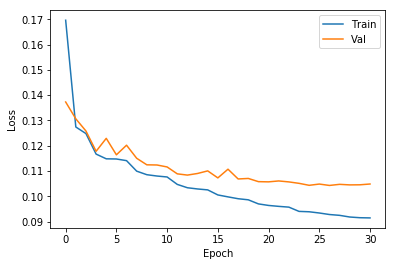

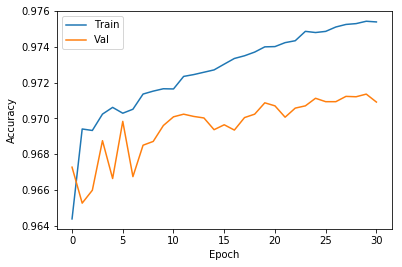

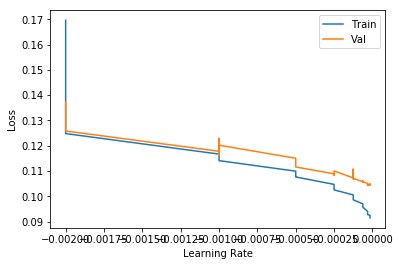

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],label='Train')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val')
  #plt.ylim([0,5])
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],label='Train')
  plt.plot(hist['epoch'], hist['val_acc'],label = 'Val')
  #plt.ylim([0,20])
  plt.legend()
  plt.figure()
  plt.xlabel('Learning Rate')
  plt.ylabel('Loss')
  plt.plot(hist['lr']*-1, hist['loss'],label='Train')
  plt.plot(hist['lr']*-1, hist['val_loss'],label = 'Val')
  plt.legend()
  plt.show()


plot_history(history)

In [28]:
x_test = test[PREDICTORS]
sub = pd.read_csv(f'../input/ieee-fraud-detection/sample_submission.csv')
sub[TARGET] = model.predict(x_test)[:,1]
sub.head()

,TransactionID,isFraud
0,3663549,0.002998
1,3663550,0.009283
2,3663551,0.015605
3,3663552,0.003081
4,3663553,0.111815


In [29]:
sub.to_csv('submission.csv', index=False)
print(os.listdir("."))

['__output__.json', '__notebook__.ipynb', 'submission.csv']
